In [48]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install scikit-learn
# %pip install tensorflow

In [49]:
import numpy as np
import pandas as pd

In [50]:
COMMODITY = 'magnesium'

DATE_COLUMN = 'Date'
VALUE_COLUMN = 'Value'  
QUANTITY_COLUMN = 'Std. Quantity (KG)'
UNIT_RATE_COLUMN = 'Std. Unit Rate ($/KG)'
ORIGIN_COUNTRY_COLUMN = 'Country of Origin'
DEST_COUNTRY_COLUMN = 'Country of Destination'

PETROL_FILE_PATH = '../../../volza/petroleum/petrol_crude_oil_spot_price.csv'
VOLZA_FILE_PATH = '../volza/magnesium/magnesium.csv'
PRICE_FILE_PATH = "../volza/magnesium/magnesium_price_2.csv"

In [51]:
# Only keep rows where we have usable quantity units (kg, ton) and standardizing it.
def convert_to_kg(df, quantity_col='Std. Quantity', unit_col='Std. Unit'):
    converstion_factors = {
        'TON': 907.185,
        'TNE': 1000,
        'KGS': 1,
        'Kgs': 1,
    }

    df_filtered = df[df[unit_col].isin(converstion_factors.keys())]

    def convert(row):
        unit = row[unit_col]
        quantity = row[quantity_col]
        return quantity * converstion_factors.get(unit,1)
    
    df_filtered = df_filtered[df_filtered[VALUE_COLUMN] != 0]
    df_filtered[QUANTITY_COLUMN] = df_filtered.apply(convert, axis=1)
    df_filtered = df_filtered[df_filtered[QUANTITY_COLUMN] != 0]

    df_filtered[UNIT_RATE_COLUMN] = df_filtered[VALUE_COLUMN] / df_filtered[QUANTITY_COLUMN]

    return df_filtered

## Spike detection

In [52]:
from datetime import datetime

#Formatting the date and price for Volza data
volza_pd = pd.read_csv(VOLZA_FILE_PATH)
volza_pd = volza_pd[(volza_pd["Country of Origin"].notnull()) & (volza_pd["Country of Destination"].notnull())]
volza_pd = volza_pd.rename(columns={'Unnamed: 0': 'ID'})
volza_pd['Date'] = volza_pd['Date'].apply(lambda x: x.split(' ')[0])
volza_pd['Date'] = pd.to_datetime(volza_pd['Date'], errors='raise', format='%Y-%m-%d')
volza_pd = convert_to_kg(volza_pd)
volza_pd

,ID,Date,HS Code,Product Description,Consignee,Notify Party Name,Shipper,Std. Quantity,Std. Unit,Standard Unit Rate INR,...,Freight Term,Marks Number,HS Product Description,Gross Weight,Consignee Address,Shipper Address,Notify Party Address,Country Name,Std. Quantity (KG),Std. Unit Rate ($/KG)
0,0,2020-06-09,8104110000,MAGNESIUM METALLIC,CORPORACION ECUATORIANA DE ALUMINIO S A CEDAL,NaN,Ningbo Distant Chemicals Co Ltd,5984.0,KGS,-,...,-,-,Con un contenido de magnesio superior o igual ...,0.0,NaN,"Jingjia Road 188 Long Unit, Jiangdong, Ningbo,...",NaN,Ecuador T3+ Import,5984.0,3.025790
1,1,2020-11-25,8104110000,MAGNESIUM METALLIC INGOTS 99.95%,CORPORACION ECUATORIANA DE ALUMINIO S A CEDAL,NaN,Ningbo Distant Chemicals Co Ltd,3000.0,KGS,-,...,-,-,Con un contenido de magnesio superior o igual ...,0.0,NaN,"Jingjia Road 188 Long Unit, Jiangdong, Ningbo,...",NaN,Ecuador T3+ Import,3000.0,3.057833
3,3,2020-07-30,81041100,MAGNESIUM INGOT,PT LAUTAN LUAS TBK,NaN,POINTER INVESTEMT HK LTD,25.0,TNE,-,...,-,-,NaN,0.0,"Graha Indramas, Gedung, Jl. Ks. Tubun No.77, R...",RM 3408 CHINA MERCHANTS TOWER|SHUN TAK CENTRE ...,NaN,Indonesia T3 Import,25000.0,1.940000
4,4,2020-04-15,81041100,"MAGNESIUM INGOT ; SIZE : 7,5 KG",PT METALURGI MITRA ABADI,NaN,UPET INDUSTRIES CO LIMITED,13.0,TNE,-,...,-,-,NaN,0.0,KAWASAN GRAHA BALARAJA INDUSTRIAL ESTATE KAV.F...,"RM 19C LOCKHART CTR 301-307 LOCKHART RD WAN, CHAI",NaN,Indonesia T3 Import,13000.0,2.381850
5,5,2020-03-27,81041100,MAGNESIUM INGOTS 300G,PT LAUTAN LUAS TBK,NaN,POINTER INVESTEMT HK LTD,2.0,TNE,-,...,-,-,NaN,0.0,"Graha Indramas, Gedung, Jl. Ks. Tubun No.77, R...",RM 3408 CHINA MERCHANTS TOWER|SHUN TAK CENTRE ...,NaN,Indonesia T3 Import,2000.0,2.430000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10463,10463,2022-11-08,81041101,"UNWROUGHT MAGNESIUM , WITH>= 99.8% OF MAGNESIUM",INTERAMERICANA DE METALES SA DE,NaN,HOESCH METALLURGIE GMBH NEU STRASSE 21,20000.0,KGS,-,...,-,-,MAGNESIO METALICO AL 999% EN PESO,20090.0,"HERACLITO NO. 307, POLANCO V SECCION|C. P. 115...",52382 NIEDERZIER GERMANY,NaN,Mexico T3 Import,20000.0,4.029999
10464,10464,2022-02-11,81041101,MAGNESIO EN PIEZAS,Z To Order and NA,NaN,OXBOW METALES MEXICO S DE R L DE C V,1000.0,KGS,-,...,-,-,MAGNESIO EN PIEZAS,0.0,NaN,AVENIDA RR,NaN,Mexico T3 Export,1000.0,12.250000
10465,10465,2022-06-14,81041101,MAGNESIO EN PIEZAS,Z To Order and NA,NaN,OXBOW METALES MEXICO S DE R L DE C V,2000.0,KGS,-,...,-,-,MAGNESIO EN PIEZAS,0.0,NaN,AVENIDA RR,NaN,Mexico T3 Export,2000.0,12.100000
10466,10466,2022-05-12,81041101,MAGNESIO EN PIEZAS,Z To Order and NA,NaN,OXBOW METALES MEXICO S DE R L DE C V,2000.0,KGS,-,...,-,-,MAGNESIO EN PIEZAS,0.0,NaN,AVENIDA RR,NaN,Mexico T3 Export,2000.0,12.100000


In [53]:
#Preprocessing the price data
prices_pd = pd.read_csv(PRICE_FILE_PATH)
prices_pd['Date'] = prices_pd['Date'].apply(lambda x: datetime.strptime(x, "%b %d, %Y").strftime("%Y-%m-%d"))
prices_pd['Date'] = pd.to_datetime(prices_pd['Date'], errors='raise', format='%Y-%m-%d')
prices_pd['Price'] = prices_pd['Price'].str.replace(',', '').astype(float)
prices_pd = prices_pd[['Date','Price']]
prices_pd

,Date,Price
0,2022-12-30,21650.0
1,2022-12-29,21650.0
2,2022-12-28,21650.0
3,2022-12-27,21700.0
4,2022-12-26,21700.0
...,...,...
711,2020-01-08,14050.0
712,2020-01-07,14100.0
713,2020-01-06,14100.0
714,2020-01-03,14100.0


In [54]:
#Aggregate volza data by day
date_wise_volza = volza_pd.groupby("Date")[['Value',QUANTITY_COLUMN,'Gross Weight']].sum()

In [55]:
prices_pd = prices_pd.set_index('Date')
aggregated_df = date_wise_volza.join(prices_pd, how="left").fillna(method='ffill')

C:\Users\manim\AppData\Local\Temp\ipykernel_29988\3127498705.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aggregated_df = date_wise_volza.join(prices_pd, how="left").fillna(method='ffill')


In [56]:
## Detecting spikes
window_size = 20  # Adjust the window size based on your data
moving_avg = aggregated_df['Price'].rolling(window=window_size).mean()
std_dev = aggregated_df['Price'].rolling(window=window_size).std()

# Set a threshold to identify spikes
threshold = 2  # You can adjust this value based on your data
spikes = (abs(aggregated_df['Price'] - moving_avg) > threshold * std_dev)
aggregated_df['spikes'] = (abs(aggregated_df['Price'] - moving_avg) > threshold * std_dev).astype(int)

In [57]:
#remove date 2020-01-01
aggregated_df = aggregated_df[aggregated_df.index != '2020-01-01']
aggregated_df

,Value,Std. Quantity (KG),Gross Weight,Price,spikes
Date,,,,,
2020-01-02,1.125000e+05,50000.00,50080.0,14150.0,0
2020-01-03,8.744076e+05,100172.26,25040.0,14100.0,0
2020-01-04,2.950597e+05,135000.00,0.0,14100.0,0
2020-01-05,4.420000e+04,20000.00,0.0,14100.0,0
2020-01-06,1.780024e+04,5001.00,2218.5,14100.0,0
...,...,...,...,...,...
2022-12-27,9.624998e+04,25000.00,25040.0,21700.0,0
2022-12-28,1.122651e+06,286996.89,80306.0,21650.0,0
2022-12-29,1.303649e+06,356878.00,0.0,21650.0,0


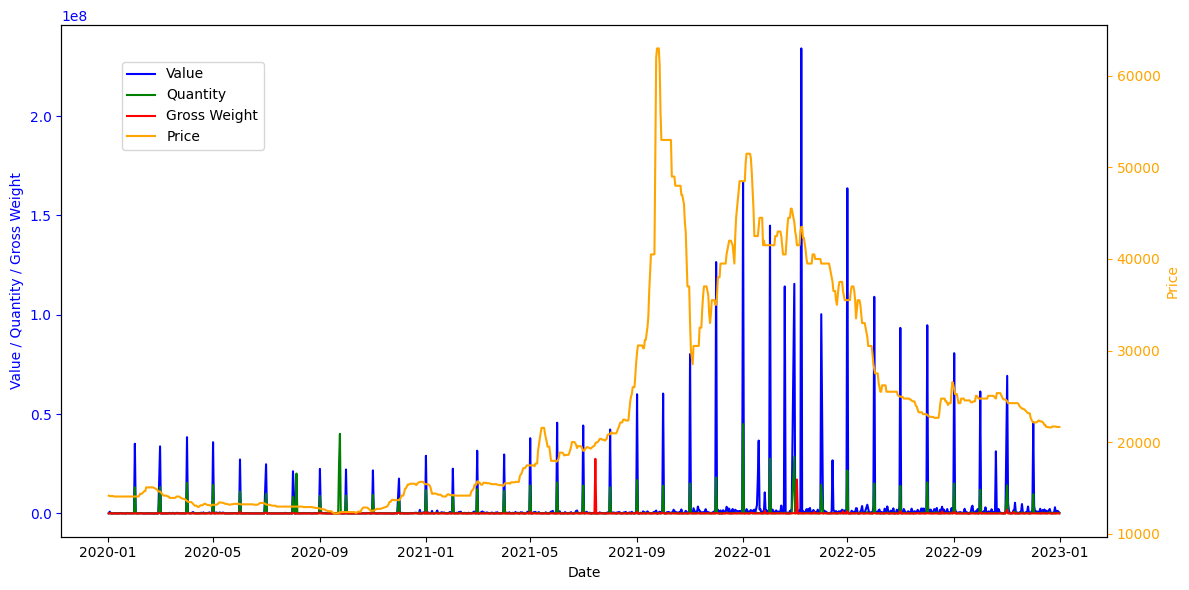

In [58]:
#Visualise Dataset

import matplotlib.pyplot as plt
# Plotting the graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting 'Value', 'Quantity', and 'Gross Weight' on the left y-axis
ax1.plot(aggregated_df.index, aggregated_df['Value'], label='Value', color='b')
ax1.plot(aggregated_df.index, aggregated_df[QUANTITY_COLUMN], label='Quantity', color='g')
ax1.plot(aggregated_df.index, aggregated_df['Gross Weight'], label='Gross Weight', color='r')

ax1.set_xlabel('Date')
ax1.set_ylabel('Value / Quantity / Gross Weight', color='b')
ax1.tick_params('y', colors='b')

# Creating a second y-axis for 'Price'
ax2 = ax1.twinx()
ax2.plot(aggregated_df.index, aggregated_df['Price'], label='Price', color='orange')
ax2.set_ylabel('Price', color='orange')
ax2.tick_params('y', colors='orange')

# Display legend
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the graph
plt.show()

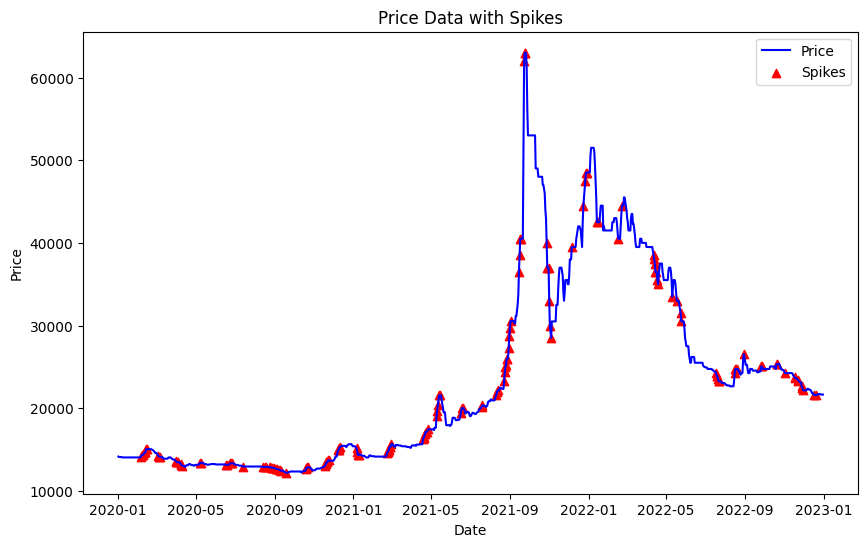

In [59]:
# Plotting the price data
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(aggregated_df.index, aggregated_df['Price'], label='Price', color='blue')

# Highlighting spikes
spike_indices = aggregated_df[aggregated_df['spikes'] == 1].index
spike_prices = aggregated_df.loc[spike_indices, 'Price']
plt.scatter(spike_indices, spike_prices, color='red', marker='^', label='Spikes')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Data with Spikes')
plt.legend()

# Display the plot
plt.show()

## Data Prep for Classification

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, SimpleRNN
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

time_series_df = aggregated_df.copy()

# Drop rows with NaN in the 'spikes' column
time_series_df = time_series_df.dropna(subset=['spikes'])

# Extract features and target variable
X = time_series_df[['Value', 'Std. Quantity (KG)', 'Gross Weight', 'Price']].values
y = time_series_df['spikes'].values

# Feature scaling using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create sequences for each sample with a window size of 20
window_size = 20
X_sequences, y_sequences = [], []

for i in range(len(X_scaled) - window_size + 1):
    X_sequences.append(X_scaled[i:i + window_size, :])
    y_sequences.append(y[i + window_size - 1])

X_sequences, y_sequences = np.array(X_sequences), np.array(y_sequences)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=50)

In [61]:
def make_output_dict(name, params, classification_report):
    return {
        "Name": name,
        "Params": params,
        "Accuracy": classification_report["accuracy"],
        "Precision (0)": classification_report["0"]["precision"],
        "Recall (0)": classification_report["0"]["recall"],
        "F1 (0)": classification_report["0"]["f1-score"],
        "Precision (1)": classification_report["1"]["precision"],
        "Recall (1)": classification_report["1"]["recall"],
        "F1 (1)": classification_report["1"]["f1-score"],
    }

output_dicts = []

In [62]:
#LSTM Model
def evaluate_lstm(num_layers: int):
  # Build the LSTM model
  model = Sequential()
  model.add(LSTM(num_layers, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

  # Train the model
  model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)


  y_pred = (model.predict(X_test) > 0.5).astype(int)


  # Generate confusion matrix
  # conf_matrix = confusion_matrix(y_test, y_pred)

  # # Calculate accuracy
  # accuracy = accuracy_score(y_test, y_pred)

  # Display confusion matrix
  # plt.figure(figsize=(6, 6))
  # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
  #             xticklabels=['No Spike', 'Spike'], yticklabels=['No Spike', 'Spike'])
  # plt.xlabel('Predicted')
  # plt.ylabel('Actual')
  # plt.title(f'Confusion Matrix\nAccuracy: {accuracy * 100:.2f}%')
  # plt.show()

  return make_output_dict(f"LSTM", f"{num_layers} layers", classification_report(y_test, y_pred, output_dict=True))


In [63]:
def evaluate_rnn(num_units: int):
    # Build the RNN model
    model = Sequential()
    model.add(SimpleRNN(num_units, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)

    # Predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Generate classification report
    return make_output_dict("RNN", f"{num_units} units", classification_report(y_test, y_pred, output_dict=True))

In [64]:
def evaluate_cnn(num_filters: int, kernel_size: int):
    # Build the CNN model
    model = Sequential()
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)

    # Predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Generate classification report
    return make_output_dict("CNN", f"{num_filters} filters, kernel size {kernel_size}", classification_report(y_test, y_pred, output_dict=True))


## LSTM (100 layers)

In [65]:
#LSTM Model

output_dicts.append(evaluate_lstm(250))
output_dicts.append(evaluate_lstm(200))
output_dicts.append(evaluate_lstm(100))
output_dicts.append(evaluate_lstm(50))

# Build the LSTM model
# model = Sequential()
# model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

# # Train the model
# print(X_train.shape)
# model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)


# y_pred = (model.predict(X_test) > 0.5).astype(int)


# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# output_dicts.append(make_output_dict("LSTM (100 layers)", "", classification_report(y_test, y_pred, output_dict=True)))

# # Display confusion matrix
# plt.figure(figsize=(6, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
#             xticklabels=['No Spike', 'Spike'], yticklabels=['No Spike', 'Spike'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix\nAccuracy: {accuracy * 100:.2f}%')
# plt.show()


6/6 [==============================] - 0s 3ms/step


In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np


def evaluate_random_forest(n_estimators):
  # Create a Random Forest Classifier
  random_forest = RandomForestClassifier(n_estimators=10, random_state=213)

  X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
  X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

  # Train the classifier
  random_forest.fit(X_train_reshaped, y_train)

  # Make predictions on the test set
  y_pred = random_forest.predict(X_test_reshaped)

  return make_output_dict("Random Forest", f"{n_estimators} Estimators", classification_report(y_test, y_pred, output_dict=True))

In [67]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Attention, Reshape
from tensorflow.keras.models import Model

def create_model(input_shape, num_classes, filters, kernel_size):
    inputs = tf.keras.Input(shape=input_shape)

    # CNN layers
    conv1 = Conv1D(filters, kernel_size=kernel_size, activation='relu')(inputs)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    # Reshape for attention
    reshape = Reshape((-1, 64))(pool1)

    # Attention mechanism
    attention = Attention()([reshape, reshape])

    # Flatten for fully connected layers
    flatten = Flatten()(attention)

    # Fully connected layers
    dense1 = Dense(128, activation='relu')(flatten)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(num_classes, activation='softmax')(dropout)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model

def evaluate_attention_cnn(filters, kernel_size):
    model = create_model(X_train.shape[1:], 2, filters, kernel_size)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=100, batch_size=filters, verbose=False)
    y_pred = model.predict(X_test)
    return make_output_dict("CNN with Attention", "", classification_report(y_test, y_pred.argmax(axis=1), output_dict=True))

output_dicts.append(evaluate_attention_cnn(32, 5))
output_dicts.append(evaluate_attention_cnn(64, 5))
output_dicts.append(evaluate_attention_cnn(128, 5))
output_dicts.append(evaluate_attention_cnn(256, 5))
output_dicts.append(evaluate_attention_cnn(64, 3))
output_dicts.append(evaluate_attention_cnn(128, 3))
output_dicts.append(evaluate_attention_cnn(256, 3))

6/6 [==============================] - 0s 2ms/step


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

## Random Forrest Classifier

In [68]:
output_dicts.append(evaluate_random_forest(50))
output_dicts.append(evaluate_random_forest(25))
output_dicts.append(evaluate_random_forest(20))
output_dicts.append(evaluate_random_forest(10))
output_dicts.append(evaluate_random_forest(5))

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# import numpy as np

# # Create a Random Forest Classifier
# random_forest = RandomForestClassifier(n_estimators=10, random_state=213)

# X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
# X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# # Train the classifier
# random_forest.fit(X_train_reshaped, y_train)

# # Make predictions on the test set
# y_pred = random_forest.predict(X_test_reshaped)

# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# output_dicts.append(make_output_dict("Random Forest", f"", classification_report(y_test, y_pred, output_dict=True)))

# # Display confusion matrix
# plt.figure(figsize=(6, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
#             xticklabels=['No Spike', 'Spike'], yticklabels=['No Spike', 'Spike'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix\nAccuracy: {accuracy * 100:.2f}%')
# plt.show()


## RNN

In [69]:
output_dicts.append(evaluate_rnn(200))
output_dicts.append(evaluate_rnn(150))
output_dicts.append(evaluate_rnn(100))
output_dicts.append(evaluate_rnn(50))


6/6 [==============================] - 0s 1ms/step


## CNN

In [70]:
output_dicts.append(evaluate_cnn(64, 3))
output_dicts.append(evaluate_cnn(128, 3))
output_dicts.append(evaluate_cnn(256, 3))
output_dicts.append(evaluate_cnn(64, 5))
output_dicts.append(evaluate_cnn(128, 5))
output_dicts.append(evaluate_cnn(256, 5))

6/6 [==============================] - 0s 1ms/step


In [71]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Attention, Reshape
from tensorflow.keras.models import Model

def create_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # CNN layers
    conv1 = Conv1D(32, kernel_size=3, activation='relu')(inputs)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(64, kernel_size=3, activation='relu')(pool1)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    # Reshape for attention
    reshape = Reshape((-1, 64))(pool2)

    # Attention mechanism
    attention = Attention()([reshape, reshape])

    # Flatten for fully connected layers
    flatten = Flatten()(attention)

    # Fully connected layers
    dense1 = Dense(128, activation='relu')(flatten)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(num_classes, activation='softmax')(dropout)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model

create_model((X_train.shape[1], X_train.shape[2]), 2)

In [72]:
output_dicts = pd.DataFrame(output_dicts)
output_dicts.to_csv(f"{COMMODITY}_model_performance.csv")
output_dicts

,Name,Params,Accuracy,Precision (0),Recall (0),F1 (0),Precision (1),Recall (1),F1 (1)
0,LSTM,250 layers,0.831579,0.893491,0.915152,0.904192,0.333333,0.28,0.304348
1,LSTM,200 layers,0.868421,0.893258,0.963636,0.927114,0.500000,0.24,0.324324
2,LSTM,100 layers,0.847368,0.904762,0.921212,0.912913,0.409091,0.36,0.382979
3,LSTM,50 layers,0.831579,0.875706,0.939394,0.906433,0.230769,0.12,0.157895
4,CNN with Attention,,0.847368,0.873626,0.963636,0.916427,0.250000,0.08,0.121212
5,CNN with Attention,,0.863158,0.871658,0.987879,0.926136,0.333333,0.04,0.071429
6,CNN with Attention,,0.847368,0.865591,0.975758,0.917379,0.000000,0.00,0.000000
7,CNN with Attention,,0.863158,0.867725,0.993939,0.926554,0.000000,0.00,0.000000
8,CNN with Attention,,0.847368,0.873626,0.963636,0.916427,0.250000,0.08,0.121212
9,CNN with Attention,,0.852632,0.866310,0.981818,0.920455,0.000000,0.00,0.000000


## OEC Trade Data

In [73]:
# oed_data = spark.read.csv("/Users/harshdeepsingh/Downloads/trade_i_baci_a_12.tsv", header=True, sep="\t")

In [74]:
# oed_data.printSchema()
# magnesium_data = oed_data.filter(col("hs_code").like("8104%"))

In [75]:
# exported_mag_data = oed_data.groupBy("year","exporter_name").agg(F.sum("value").alias("export_value"),F.sum("quantity").alias("export_quantity"))

In [76]:
# temp = exported_mag_data.withColumn("mag_price_calc", col("export_value")/col("export_quantity")).orderBy("year")

In [77]:
# temp.filter("exporter_name == 'China'").show()